# Programming Exercise 4: Neural Networks Learning¶

In this exercise, i will implement the backpropagation algorithm for neural networks and apply it to the task of hand-written digit recognition.

In [1]:
import os
import numpy as np
from matplotlib import pyplot
from scipy import optimize
from scipy.io import loadmat
import utils
import pandas as pd
grader = utils.Grader()

%matplotlib inline

## Neural Networks
In the previous exercise, i implemented feedforward propagation for neural networks and used it to predict handwritten digits with the already provided weights. In this exercise, i will implement the backpropagation algorithm to learn the parameters for the neural network.

Start the exercise by first loading the dataset.

In [2]:
data = loadmat(os.path.join('Data', 'ex4data1.mat'))
X, y = data['X'], data['y']

y[y==10] = 0

m = y.size
print(X.shape)
print(y.shape)

(5000, 400)
(5000, 1)


## Visualizing the data

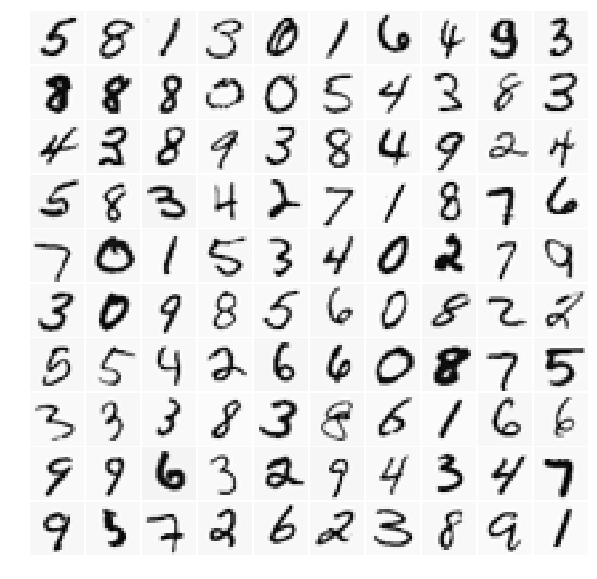

In [3]:
rand_indices = np.random.choice(m, 100, replace = False)
sel = X[rand_indices, :]

utils.displayData(sel)

## 1.2 Model representation
Our neural network is shown in the following figure.

![Neural Network](Figures/neural_network.png)

It has 3 layers - an input layer, a hidden layer and an output layer. Recall that inputs are pixel values of digit images. Since the images are of size $20 \times 20$, this gives us 400 input layer units (not counting the extra bias unit which always outputs +1). The training data was loaded into the variables X and y above.

You have been provided with a set of network parameters ($\Theta^{(1)}, \Theta^{(2)}$) already trained by us. These are stored in ex4weights.mat and will be loaded in the next cell of this notebook into Theta1 and Theta2. The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).

In [4]:

# Setup the parameters you will use for this exercise
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10          # 10 labels, from 0 to 9

# Load the weights into variables Theta1 and Theta2
weights = loadmat(os.path.join('Data', 'ex4weights.mat'))

# Theta1 has size 25 x 401
# Theta2 has size 10 x 26
Theta1, Theta2 = weights['Theta1'], weights['Theta2']

# swap first and last columns of Theta2, due to legacy from MATLAB indexing, 
# since the weight file ex3weights.mat was saved based on MATLAB indexing
Theta2 = np.roll(Theta2, 1, axis=0)

# Unroll parameters 
nn_params = np.concatenate([Theta1.ravel(), Theta2.ravel()])

## 1.3 Feedforward and cost function
Now you will implement the cost function and gradient for the neural network. First, complete the code for the function nnCostFunction in the next cell to return the cost.

Recall that the cost function for the neural network (without regularization) is:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right]$$
where $h_\theta \left( x^{(i)} \right)$ is computed as shown in the neural network figure above, and K = 10 is the total number of possible labels. Note that $h_\theta(x^{(i)})_k = a_k^{(3)}$ is the activation (output value) of the $k^{th}$ output unit. Also, recall that whereas the original labels (in the variable y) were 0, 1, ..., 9, for the purpose of training a neural network, we need to encode the labels as vectors containing only values 0 or 1, so that

$$ y = 
\begin{bmatrix} 1 \\ 0 \\ 0 \\\vdots \\ 0 \end{bmatrix}, \quad
\begin{bmatrix} 0 \\ 1 \\ 0 \\ \vdots \\ 0 \end{bmatrix}, \quad \cdots  \quad \text{or} \qquad
\begin{bmatrix} 0 \\ 0 \\ 0 \\ \vdots \\ 1 \end{bmatrix}.
$$
For example, if $x^{(i)}$ is an image of the digit 5, then the corresponding $y^{(i)}$ (that you should use with the cost function) should be a 10-dimensional vector with $y_5 = 1$, and the other elements equal to 0.

Implement the feedforward computation that computes $h_\theta(x^{(i)})$ for every example $i$ and sum the cost over all examples. Your code should also work for a dataset of any size, with any number of labels (you can assume that there are always at least $K \ge 3$ labels).

In [42]:
def nnCostFunction(nn_params,
                   input_layer_size,
                   hidden_layer_size,
                   num_labels,
                   X, y, lambda_=0.0):
    """
    Implements the neural network cost function and gradient for a two layer neural 
    network which performs classification. 
    
    Parameters
    ----------
    nn_params : array_like
        The parameters for the neural network which are "unrolled" into 
        a vector. This needs to be converted back into the weight matrices Theta1
        and Theta2.
    
    input_layer_size : int
        Number of features for the input layer. 
    
    hidden_layer_size : int
        Number of hidden units in the second layer.
    
    num_labels : int
        Total number of labels, or equivalently number of units in output layer. 
    
    X : array_like
        Input dataset. A matrix of shape (m x input_layer_size).
    
    y : array_like
        Dataset labels. A vector of shape (m,).
    
    lambda_ : float, optional
        Regularization parameter.
 
    Returns
    -------
    J : float
        The computed value for the cost function at the current weight values.
    
    grad : array_like
        An "unrolled" vector of the partial derivatives of the concatenatation of
        neural network weights Theta1 and Theta2.
    
    Instructions
    ------------
    You should complete the code by working through the following parts.
    
    - Part 1: Feedforward the neural network and return the cost in the 
              variable J. After implementing Part 1, you can verify that your
              cost function computation is correct by verifying the cost
              computed in the following cell.
    
    - Part 2: Implement the backpropagation algorithm to compute the gradients
              Theta1_grad and Theta2_grad. You should return the partial derivatives of
              the cost function with respect to Theta1 and Theta2 in Theta1_grad and
              Theta2_grad, respectively. After implementing Part 2, you can check
              that your implementation is correct by running checkNNGradients provided
              in the utils.py module.
    
              Note: The vector y passed into the function is a vector of labels
                    containing values from 0..K-1. You need to map this vector into a 
                    binary vector of 1's and 0's to be used with the neural network
                    cost function.
     
              Hint: We recommend implementing backpropagation using a for-loop
                    over the training examples if you are implementing it for the 
                    first time.
    
    - Part 3: Implement regularization with the cost function and gradients.
    
              Hint: You can implement this around the code for
                    backpropagation. That is, you can compute the gradients for
                    the regularization separately and then add them to Theta1_grad
                    and Theta2_grad from Part 2.

    """
    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for our 2 layer neural network
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, (input_layer_size + 1)))

    Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                        (num_labels, (hidden_layer_size + 1)))

    # Setup some useful variables
    m = y.size
         
    # You need to return the following variables correctly 
    J = 0
    Theta1_grad = np.zeros(Theta1.shape) #25x401
    Theta2_grad = np.zeros(Theta2.shape) #10x26
    
    #================== Feed-forward =====================
    
    X = np.concatenate([np.ones((m,1)), X], axis = 1)
    a1 = X
    a2 = utils.sigmoid(a1 @ Theta1.T) #5000x401 x 401x25
    a2 = np.hstack((np.ones((m,1)), a2)) 
    h = utils.sigmoid(a2 @ Theta2.T) #5000x26 x 26x10
    
    # to create a 5000x10 as output
    y_d = pd.get_dummies(y.flatten())

    temp1 = np.multiply(y_d, np.log(h)) # 5000x10
    temp2 = np.multiply(1 - y_d, np.log(1 - h))
    temp3 = np.sum(temp1 + temp2)
    
    # ================== Regularization ===================
    
    sum1 = np.sum(np.sum(np.power(Theta1[:,1:], 2), axis = 1))
    sum2 = np.sum(np.sum(np.power(Theta2[:,1:], 2), axis = 1))
    
    #======================== Cost ========================
    J = np.sum(temp3 / (-m)) + (sum1 + sum2)*lambda_/(2*m)
    
    #=================== Backpropagation ===================
    
     
    
    # Unroll gradients
    # grad = np.concatenate([Theta1_grad.ravel(order=order), Theta2_grad.ravel(order=order)])
    grad = np.concatenate([Theta1_grad.ravel(), Theta2_grad.ravel()])

    return J, grad

Once you are done, call your nnCostFunction using the loaded set of parameters for Theta1 and Theta2. You should see that the cost is about 0.287629.

In [43]:
lambda_ = 0
J, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                   num_labels, X, y, lambda_)
print('Cost at parameters (loaded from ex4weights): %.6f ' % J)
print('The cost should be about                   : 0.287629.')

Cost at parameters (loaded from ex4weights): 0.287629 
The cost should be about                   : 0.287629.


In [37]:

grader = utils.Grader()
grader[1] = nnCostFunction
grader.grade()


Submitting Solutions | Programming Exercise neural-network-learning

Use token from last successful submission (markostojanovic3012@gmail.com)? (Y/n): y
(4, 3)
-49.39918653053829
                                  Part Name |     Score | Feedback
                                  --------- |     ----- | --------
              Feedforward and Cost Function |  30 /  30 | Nice work!
                  Regularized Cost Function |   0 /  15 | 
                           Sigmoid Gradient |   0 /   5 | 
  Neural Network Gradient (Backpropagation) |   0 /  40 | 
                       Regularized Gradient |   0 /  10 | 
                                  --------------------------------
                                            |  30 / 100 |  



## 1.4 Regularized cost function
The cost function for neural networks with regularization is given by:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right] + \frac{\lambda}{2 m} \left[ \sum_{j=1}^{25} \sum_{k=1}^{400} \left( \Theta_{j,k}^{(1)} \right)^2 + \sum_{j=1}^{10} \sum_{k=1}^{25} \left( \Theta_{j,k}^{(2)} \right)^2 \right] $$
You can assume that the neural network will only have 3 layers - an input layer, a hidden layer and an output layer. However, code should work for any number of input units, hidden units and outputs units. Note that you should not be regularizing the terms that correspond to the bias. Notice that you can first compute the unregularized cost function $J$ using your existing nnCostFunction and then later add the cost for the regularization terms.

Once done, the next cell will call nnCostFunction using the loaded set of parameters for Theta1 and Theta2, and $\lambda = 1$. The cost should be about 0.383770.

In [44]:
# Weight regularization parameter (we set this to 1 here).
lambda_ = 1
J, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                      num_labels, X, y, lambda_)

print('Cost at parameters (loaded from ex4weights): %.6f' % J)
print('This value should be about                 : 0.383770.')

Cost at parameters (loaded from ex4weights): 0.383770
This value should be about                 : 0.383770.


In [45]:

grader[2] = nnCostFunction
grader.grade()


Submitting Solutions | Programming Exercise neural-network-learning

Use token from last successful submission (markostojanovic3012@gmail.com)? (Y/n): y
(4, 3)
-49.39918653053829
                                  Part Name |     Score | Feedback
                                  --------- |     ----- | --------
              Feedforward and Cost Function |  30 /  30 | Nice work!
                  Regularized Cost Function |  15 /  15 | Nice work!
                           Sigmoid Gradient |   0 /   5 | 
  Neural Network Gradient (Backpropagation) |   0 /  40 | 
                       Regularized Gradient |   0 /  10 | 
                                  --------------------------------
                                            |  45 / 100 |  



# 2 Backpropagation
In this part of the exercise, i will implement the backpropagation algorithm to compute the gradient for the neural network cost function. Once you have computed the gradient, you will be able to train the neural network by minimizing the cost function $J(\theta)$ using an advanced optimizer such as scipy's optimize.minimize. I will first implement the backpropagation algorithm to compute the gradients for the parameters for the (unregularized) neural network. After verifying that gradient computation for the unregularized case is correct, i will implement the gradient for the regularized neural network.


## 2.1 Sigmoid Gradient
The gradient for the sigmoid function can be computed as

$$ g'(z) = \frac{d}{dz} g(z) = g(z)\left(1-g(z)\right) $$
where

$$ \text{sigmoid}(z) = g(z) = \frac{1}{1 + e^{-z}} $$

In [49]:

def sigmoidGradient(z):
    """
    Computes the gradient of the sigmoid function evaluated at z. 
    This should work regardless if z is a matrix or a vector. 
    In particular, if z is a vector or matrix, you should return
    the gradient for each element.
    
    Parameters
    ----------
    z : array_like
        A vector or matrix as input to the sigmoid function. 
    
    Returns
    --------
    g : array_like
        Gradient of the sigmoid function. Has the same shape as z. 
    
    Instructions
    ------------
    Compute the gradient of the sigmoid function evaluated at
    each value of z (z can be a matrix, vector or scalar).
    
    Note
    ----
    We have provided an implementation of the sigmoid function 
    in `utils.py` file accompanying this assignment.
    """

    g = np.zeros(z.shape)

    # ============================================================

    g = np.multiply(utils.sigmoid(z), 1-utils.sigmoid(z))


    # =============================================================
    return g

In [50]:
z = np.array([-1, -0.5, 0, 0.5, 1])
g = sigmoidGradient(z)
print('Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:\n  ')
print(g)

Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:
  
[0.19661193 0.23500371 0.25       0.23500371 0.19661193]


In [51]:

grader[3] = sigmoidGradient
grader.grade()


Submitting Solutions | Programming Exercise neural-network-learning

Use token from last successful submission (markostojanovic3012@gmail.com)? (Y/n): y
(4, 3)
-49.39918653053829
                                  Part Name |     Score | Feedback
                                  --------- |     ----- | --------
              Feedforward and Cost Function |  30 /  30 | Nice work!
                  Regularized Cost Function |  15 /  15 | Nice work!
                           Sigmoid Gradient |   5 /   5 | Nice work!
  Neural Network Gradient (Backpropagation) |   0 /  40 | 
                       Regularized Gradient |   0 /  10 | 
                                  --------------------------------
                                            |  50 / 100 |  



## 2.2 Random Initialization
When training neural networks, it is important to randomly initialize the parameters for symmetry breaking. One effective strategy for random initialization is to randomly select values for $\Theta^{(l)}$ uniformly in the range $[-\epsilon_{init}, \epsilon_{init}]$. You should use $\epsilon_{init} = 0.12$. This range of values ensures that the parameters are kept small and makes the learning more efficient.

One effective strategy for choosing $\epsilon_{init}$ is to base it on the number of units in the network. A good choice of $\epsilon_{init}$ is $\epsilon_{init} = \frac{\sqrt{6}}{\sqrt{L_{in} + L_{out}}}$ where $L_{in} = s_l$ and $L_{out} = s_{l+1}$ are the number of units in the layers adjacent to $\Theta^{l}$.
Your job is to complete the function randInitializeWeights to initialize the weights for $\Theta$. Modify the function by filling in the following code:

```python
Randomly initialize the weights to small values
W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init ```

Note that we give the function an argument for $\epsilon$ with default value epsilon_init = 0.12.

In [52]:
def randInitializeWeights(L_in, L_out, epsilon_init=0.12):
    """
    Randomly initialize the weights of a layer in a neural network.
    
    Parameters
    ----------
    L_in : int
        Number of incomming connections.
    
    L_out : int
        Number of outgoing connections. 
    
    epsilon_init : float, optional
        Range of values which the weight can take from a uniform 
        distribution.
    
    Returns
    -------
    W : array_like
        The weight initialiatized to random values.  Note that W should
        be set to a matrix of size(L_out, 1 + L_in) as
        the first column of W handles the "bias" terms.
        
    Instructions
    ------------
    Initialize W randomly so that we break the symmetry while training
    the neural network. Note that the first column of W corresponds 
    to the parameters for the bias unit.
    """

    # You need to return the following variables correctly 
    W = np.zeros((L_out, 1 + L_in))

    # ======================================
    W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init
    
    return W

In [53]:
print('Initializing Neural Network Parameters ...')

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

# Unroll parameters
initial_nn_params = np.concatenate([initial_Theta1.ravel(), initial_Theta2.ravel()], axis=0)

Initializing Neural Network Parameters ...


## 2.4 Backpropagation


Now, i will implement the backpropagation algorithm. Recall that the intuition behind the backpropagation algorithm is as follows. Given a training example $(x^{(t)}, y^{(t)})$, we will first run a “forward pass” to compute all the activations throughout the network, including the output value of the hypothesis $h_\theta(x)$. Then, for each node $j$ in layer $l$, we would like to compute an “error term” $\delta_j^{(l)}$ that measures how much that node was “responsible” for any errors in our output.

For an output node, we can directly measure the difference between the network’s activation and the true target value, and use that to define $\delta_j^{(3)}$ (since layer 3 is the output layer). For the hidden units, you will compute $\delta_j^{(l)}$ based on a weighted average of the error terms of the nodes in layer $(l+1)$. In detail, here is the backpropagation algorithm (also depicted in the figure above).

1. Set the input layer’s values $(a^{(1)})$ to the $t^{th }$training example $x^{(t)}$. Perform a feedforward pass, computing the activations $(z^{(2)}, a^{(2)}, z^{(3)}, a^{(3)})$ for layers 2 and 3. Note that you need to add a +1 term to ensure that the vectors of activations for layers $a^{(1)}$ and $a^{(2)}$ also include the bias unit. In numpy, if a 1 is a column matrix, adding one corresponds to a_1 = np.concatenate([np.ones((m, 1)), a_1], axis=1).


2. For each output unit $k$ in layer 3 (the output layer), set $$\delta_k^{(3)} = \left(a_k^{(3)} - y_k \right)$$ where $y_k \in \{0, 1\}$ indicates whether the current training example belongs to class $k$ $(y_k = 1)$, or if it belongs to a different class $(y_k = 0)$. You may find logical arrays helpful for this task (explained in the previous programming exercise).

3. For the hidden layer $l = 2$, set $$ \delta^{(2)} = \left( \Theta^{(2)} \right)^T \delta^{(3)} * g'\left(z^{(2)} \right)$$ Note that the symbol $*$ performs element wise multiplication in numpy.

4. Accumulate the gradient from this example using the following formula. Note that you should skip or remove $\delta_0^{(2)}$. In numpy, removing $\delta_0^{(2)}$ corresponds to delta_2 = delta_2[1:].

5. Obtain the (unregularized) gradient for the neural network cost function by dividing the accumulated gradients by $\frac{1}{m}$: $$ \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)}$$

**Python/Numpy tip**: You should implement the backpropagation algorithm only after you have successfully completed the feedforward and cost functions. While implementing the backpropagation alogrithm, it is often useful to use the `shape` function to print out the shapes of the variables you are working with if you run into dimension mismatch errors.
Click here to go back and update the function nnCostFunction with the backpropagation algorithm.

After you have implemented the backpropagation algorithm, we will proceed to run gradient checking on your implementation. The gradient check will allow you to increase your confidence that your code is computing the gradients correctly.